# Laplace Mechanism Basics #

The Laplace Mechanism adds noise drawn from a Laplace distribution to realize differential privacy.

This mechanism works well for computing means and histograms, providing accurate results at minimal privacy budgets.

This notebook walks through the basic `eeprivacy` functions for working with the Laplace Mechanism.

In [1]:
# Preamble: imports and figure settings

from eeprivacy.mechanisms import LaplaceMechanism
from eeprivacy.operations import (
  PrivateClampedMean,
  PrivateHistogram,
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
from scipy import stats

np.random.seed(1234) # Fix seed for deterministic documentation

mpl.style.use("seaborn-white")

MD = 28
LG = 36
plt.rcParams.update({
    "figure.figsize": [25, 10],
    "legend.fontsize": MD,
    "axes.labelsize": LG,
    "axes.titlesize": LG,
    "xtick.labelsize": LG,
    "ytick.labelsize": LG,
})

## Distribution of Laplace Mechanism Outputs ##

For a given ε, noise is drawn from the Laplace distribution at `b`=`sensitivity`/ε. The `eeprivacy` class `LaplaceMechanism` draws this noise and adds it to a private value:

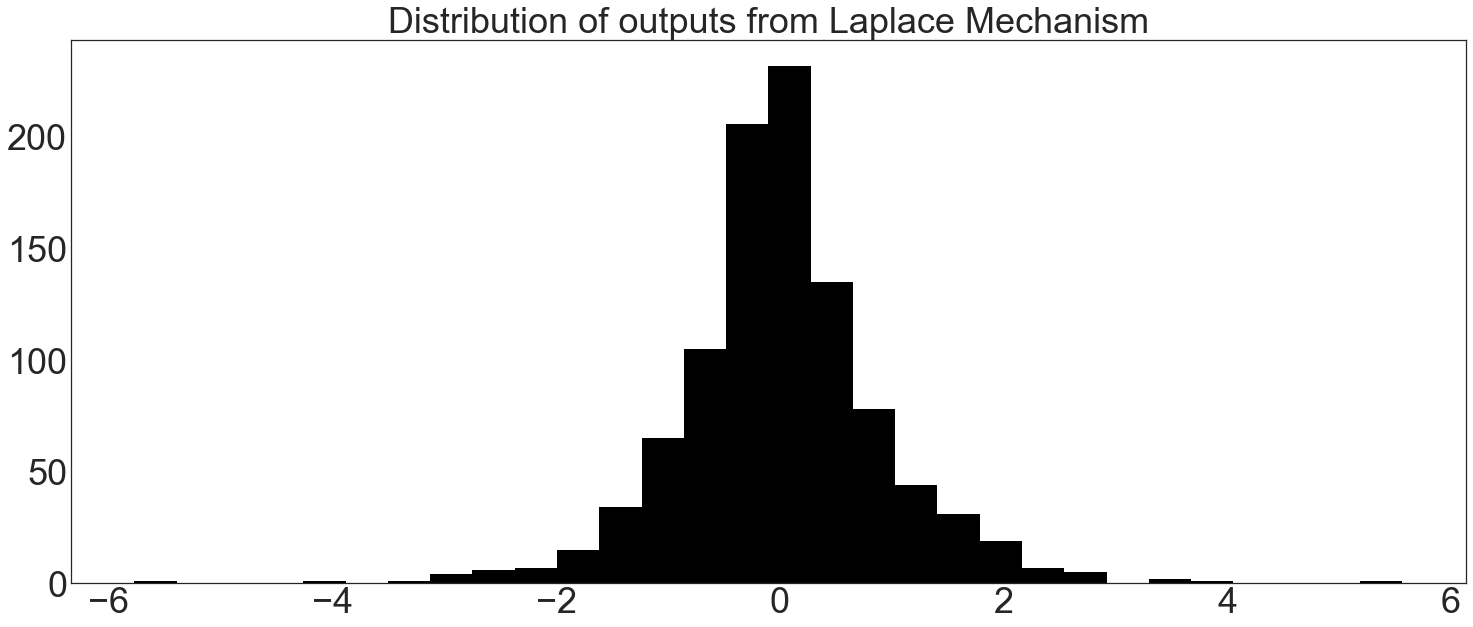

In [8]:
trials = []
for t in range(1000):
  trials.append(LaplaceMechanism.execute(
    value=0,
    epsilon=0.1,
    sensitivity=199/3000
  ))

plt.hist(trials, bins=30, color="k")
plt.title("Distribution of outputs from Laplace Mechanism")
plt.show()

## Laplace Mechanism Confidence Interval ##

With the `eeprivacy` confidence interval functions, analysts can determine how far away the true value of a statistics is from the differentially private result.

To determine the confidence interval for a given choice of privacy parameters, employ `eeprivacy.laplace_mechanism_confidence_interval`.

To determine the privacy parameters for a desired confidence interval, employ `eeprivacy.laplace_mechanism_epsilon_for_confidence_interval`.

The confidence intervals reported below are two-sided. For example, for a 95% confidence interval of +/-10, 2.5% of results will be smaller than -10 and 2.5% of results will be larger than +10.


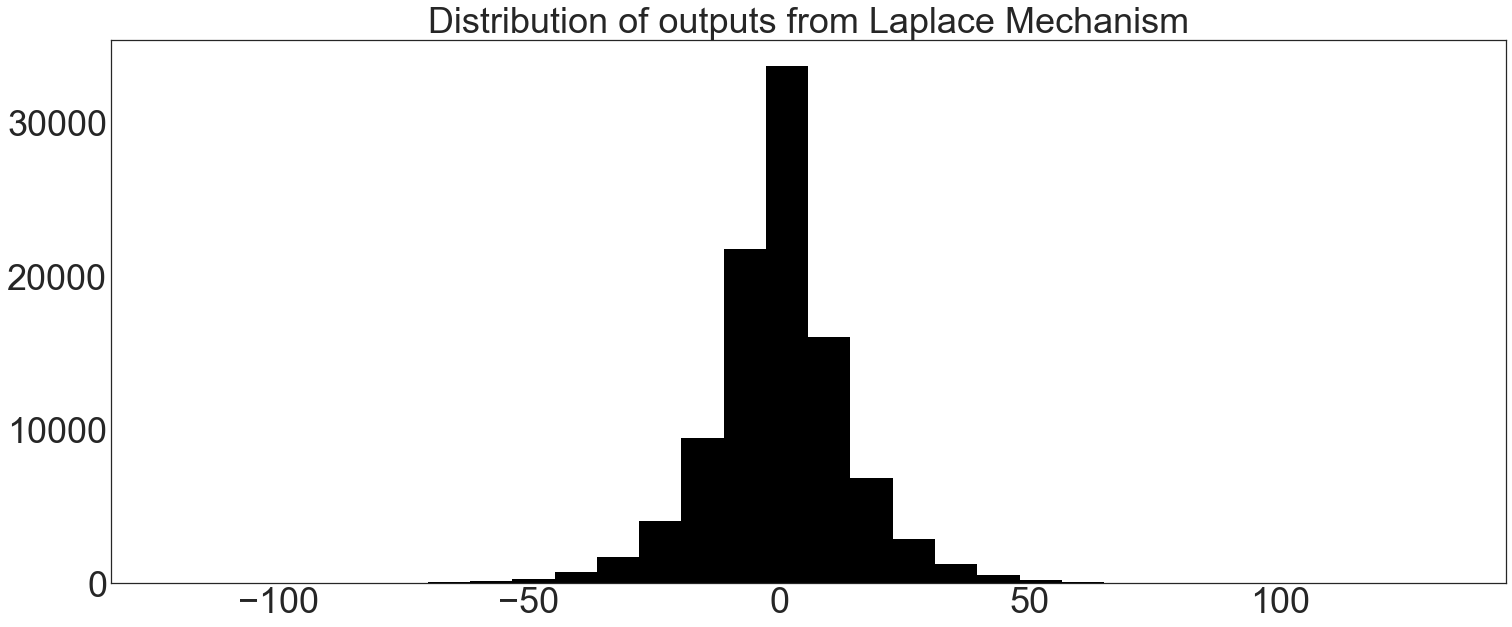

95% Confidence Interval (Stochastic): 30.05118474953303
95% Confidence Interval (Exact): 29.9573227355399
ε for confidence interval: 0.100001077329305


In [5]:
trials = []
for t in range(100000):
  trials.append(LaplaceMechanism.execute(
    value=0,
    epsilon=0.1,
    sensitivity=1
  ))

plt.hist(trials, bins=30, color="k")
plt.title("Distribution of outputs from Laplace Mechanism")
plt.show()

ci = np.quantile(trials, 0.975)
print(f"95% Confidence Interval (Stochastic): {ci}")

ci = LaplaceMechanism.confidence_interval(
  epsilon=0.1,
  sensitivity=1,
  confidence=0.95
)
print(f"95% Confidence Interval (Exact): {ci}")

# Now in reverse:
epsilon = LaplaceMechanism.epsilon_for_confidence_interval(
  target_ci=29.957,
  sensitivity=1,
  confidence=0.95
)
print(f"ε for confidence interval: {epsilon}")


## Examples of Laplace Mechanism Helpers using `eeprivacy` ##

The Laplace Mechanism is well-suited for computing means, and `eeprivacy` provides a helper `private_mean_with_laplace` for this use case.

The private mean function implemented by `eeprivacy` employs the "clamped mean" approach to bound sensitivity. Analysts provide a fixed `lower_bound` and `upper_bound` before computing the mean. For datasets with unknown ranges, an approach like the one described in [Computing Bounds for Clamped Means] can be used.

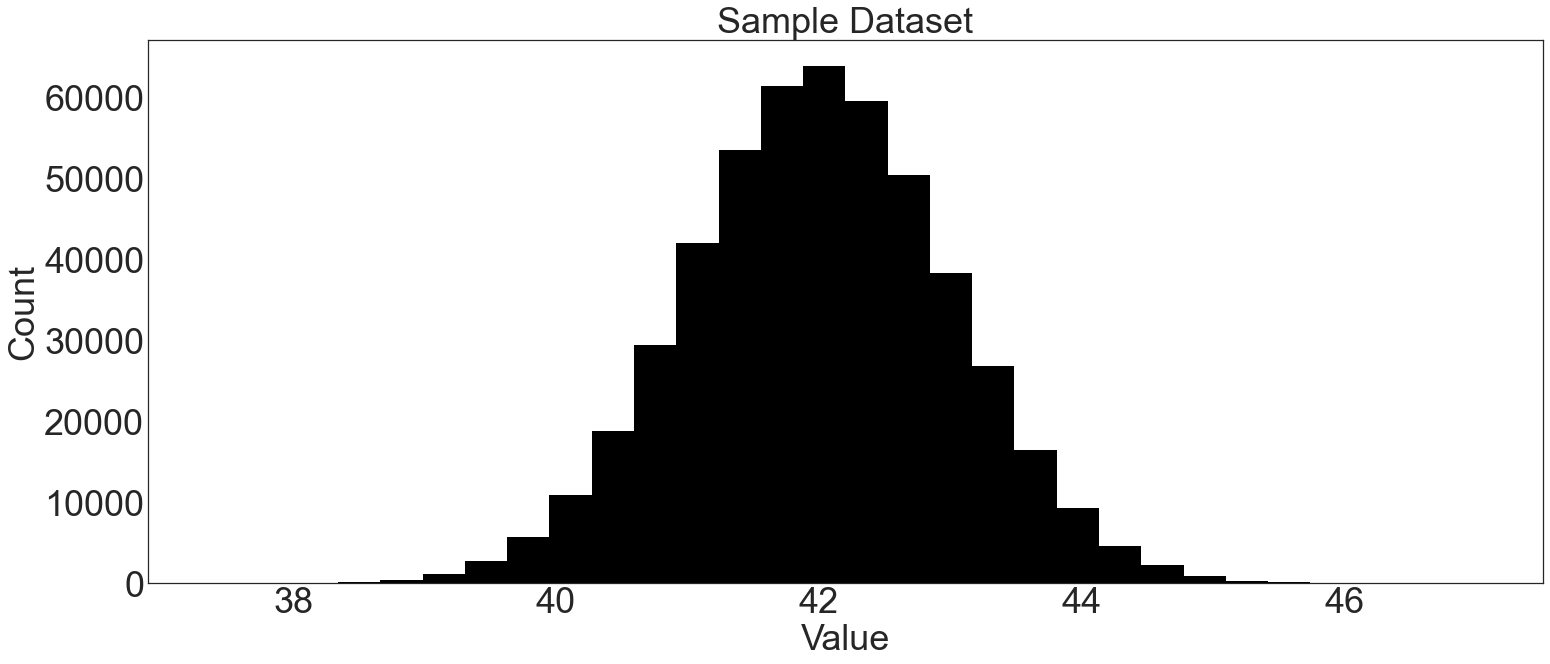

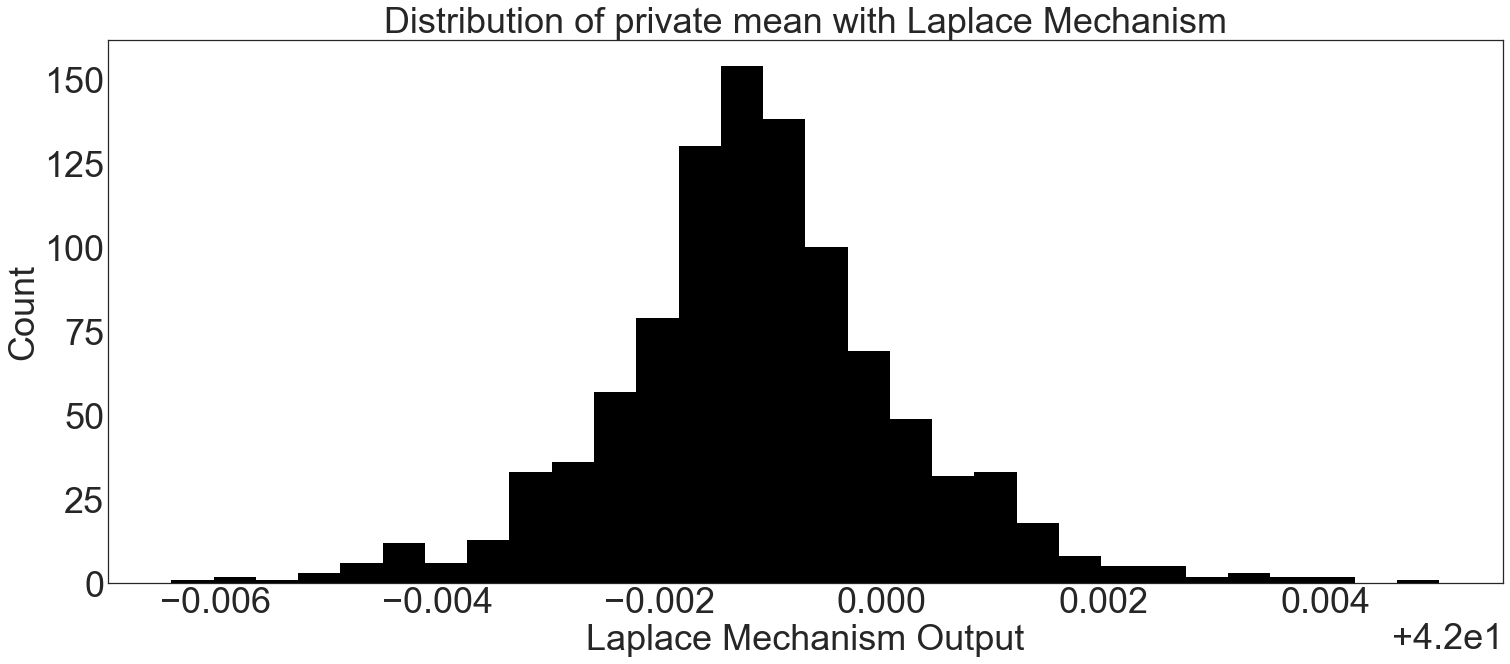

In [4]:

N = 500000
dataset = np.random.normal(loc=42, size=N)

plt.hist(dataset, bins=30, color="k")
plt.title("Sample Dataset")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()

trials = []

private_mean_op = PrivateClampedMean(
  lower_bound = 0,
  upper_bound = 50
)

for i in range(1000):
  private_mean = private_mean_op.execute(
    values=dataset,
    epsilon=0.1,
  )
  trials.append(private_mean)

plt.hist(trials, bins=30, color="k")
plt.title("Distribution of private mean with Laplace Mechanism")
plt.xlabel("Laplace Mechanism Output")
plt.ylabel("Count")
plt.show()

## Computing Private Histograms ##

The Laplace Mechanism is also well-suited for private histograms.

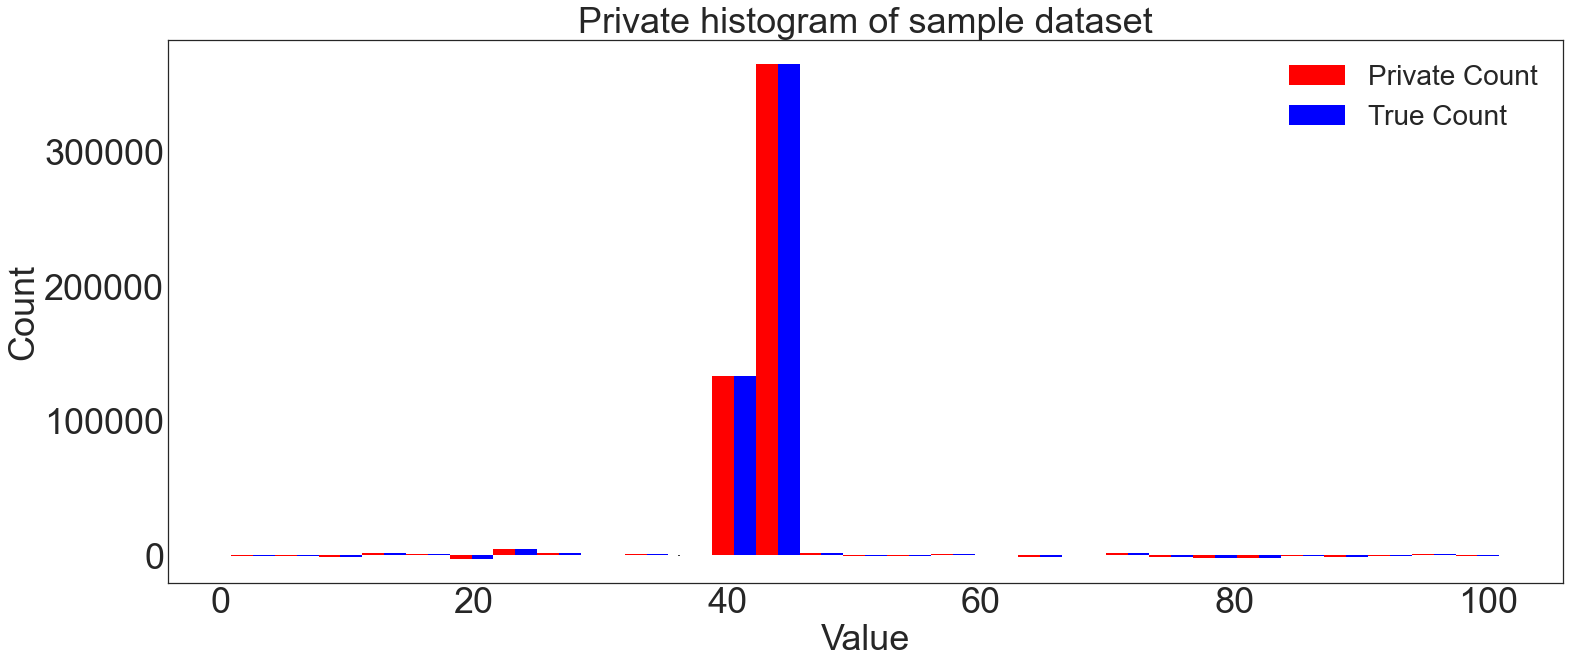

In [5]:

bins = np.linspace(start=0, stop=100, num=30)

private_histogram_op = PrivateHistogram(
  bins = bins,
)

private_histogram = private_histogram_op.execute(  
  values=dataset,
  epsilon=0.001
)

true_histogram = np.histogram(dataset, bins=bins)

bin_centers = (bins[0:-1] + bins[1:]) / 2
bin_width = bins[1] - bins[0]

fig, ax = plt.subplots()
ax.bar(
  bin_centers, 
  private_histogram, 
  width=bin_width/2, 
  yerr=ci, 
  color="r", 
  label="Private Count"
)
ax.bar(
  bin_centers+bin_width/2, 
  private_histogram, 
  width=bin_width/2, 
  color="b", 
  label="True Count"
)

plt.title("Private histogram of sample dataset")
plt.xlabel("Value")
plt.ylabel("Count")
plt.legend()
plt.show()
